In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics

# config cpu run enviroment

In [2]:
#os.environ['CUDA_VISIBLE_DEVICES']=''

# load data

In [3]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

# param config

In [4]:
class Config(object):
    """
    A class to store parameters, the input should be feature mat of training and testing
    Note: it would be more interesting to use a HyperOpt search space:
    https://github.com/hyperopt/hyperopt
    """
    def __init__(self, X_train, X_test):
        # Input data
        self.train_count = len(X_train)  # 11855 training series
        self.test_data_count = len(X_test)  # 662 testing series
        self.n_steps = len(X_train[0])  # 117 time_steps (features) per series

        # Training
        self.learning_rate = 0.0025
        self.lambda_loss_amount = 0.0015
        self.training_epochs = self.train_count * 300
        self.batch_size = 1500
        self.display_iter = 30000  # To show test set accuracy during training

        # LSTM structure
        # Features count is of 1 (1*3D sensors features over time)
        self.n_inputs = len(X_train[0][0]) # 1
        self.n_hidden = 32  # nb of neurons inside the neural network
        self.n_classes = 7  # Final output classes
        
        self.W = {
            'hidden': tf.Variable(tf.random_normal([self.n_inputs, self.n_hidden])),
            'output': tf.Variable(tf.random_normal([self.n_hidden, self.n_classes]))}
        self.biases = {
            'hidden': tf.Variable(tf.random_normal([self.n_hidden], mean=1.0)),
            'output': tf.Variable(tf.random_normal([self.n_classes]))}

# lstm network

In [5]:
def LSTM_Network(_X, config):
    """
    Two LSTM cells are stacked which adds deepness to the neural network.
    Args:
        _X: ndarray feature matrix, shape: [batch_size, time_steps, n_inputs]
        return: matrix  output shape [batch_size,n_classes]
    """
    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, config.n_inputs])
    # new shape: (n_steps*batch_size, n_input)

    # Linear activation
    _X = tf.nn.relu(tf.matmul(_X, config.W['hidden']) + config.biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, config.n_steps, 0)
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(config.n_hidden, forget_bias=1.0, 
                  state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(config.n_hidden, forget_bias=1.0, 
                  state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], 
                  state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many to one" style classifier,
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]

    # Linear activation
    return tf.matmul(lstm_last_output, config.W['output']) + config.biases['output']

# batch extract

In [6]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s

# one hot

In [7]:
def one_hot(y_):
    """
    Function to encode output labels from number indexes.
    E.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    """
    y_ = y_.reshape(len(y_))
    #n_values = int(np.max(y_)) + 1
    n_values = config.n_classes
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

# prepare data

In [15]:
labels = ['info', 'crit', 'err', 'notice', 'warning', 'alert', 'emerg']

dataset_path = "data/"
print("\n" + "Dataset is now located at: " + dataset_path)

X_train_signals_path = dataset_path + "msg_token_train.txt"
X_test_signals_path = dataset_path + "msg_token_test.txt"
X_train = load_X(X_train_signals_path)
X_test = load_X(X_test_signals_path)

y_train_path = dataset_path + "msg_label_train.txt"
y_test_path = dataset_path + "msg_label_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: data/


# define param

In [10]:
config = Config(X_train, X_test)
print("test features shape, labels shape, each features mean, each features standard deviation")
print(X_test.shape, y_test.shape,
      np.mean(X_test), np.std(X_test))
print("the dataset is properly normalised, as expected.")

test features shape, labels shape, each features mean, each features standard deviation
((8874, 120, 1), (8874, 1), 19446.971, 6505.1997)
the dataset is properly normalised, as expected.


# build the neural network

In [11]:
x = tf.placeholder(tf.float32, [None, config.n_steps, config.n_inputs])
y = tf.placeholder(tf.float32, [None, config.n_classes])

pred_y = LSTM_Network(x, config)

# Loss,optimizer,evaluation
l2 = config.lambda_loss_amount * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
# Softmax loss and L2
cost = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred_y)) + l2
optimizer = tf.train.AdamOptimizer(
    learning_rate=config.learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(pred_y, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

# train the neural network

In [12]:
# tracking training performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
# Note that log_device_placement can be turned ON but will cause console spam with RNNs.
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=False))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * config.batch_size <= config.training_epochs:
    batch_xs = extract_batch_size(X_train, step, config.batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, config.batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run([optimizer, cost, accuracy],
        feed_dict={x: batch_xs, y: batch_ys})

    train_losses.append(loss)
    train_accuracies.append(acc)  

    # Evaluate network only at some steps for faster training: 
    if (step*config.batch_size % config.display_iter == 0) or (step == 1) \
        or (step * config.batch_size > config.training_epochs):

        # To not spam console, show training accuracy/loss in this "if"
        print("Training epochs #" + str(step*config.batch_size) + \
          ":   Batch Loss = " + "{:.6f}".format(loss) + \
          ", Accuracy = {}".format(acc))

        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run([cost, accuracy], feed_dict={x: X_test, y: one_hot(y_test)})

        test_losses.append(loss)
        test_accuracies.append(acc)

        print("Performance on test set: " + "Batch Loss = {}".format(loss) + \
            ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data
one_hot_predictions, accuracy, final_loss = sess.run([pred_y, accuracy, cost],
    feed_dict={x: X_test, y: one_hot(y_test)})

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("Final result: " + "Batch Loss = {}".format(final_loss) + \
    ", Accuracy = {}".format(accuracy))

Training epochs #1500:   Batch Loss = 3.529994, Accuracy = 0.0
Performance on test set: Batch Loss = 2.53718996048, Accuracy = 0.0126211391762
Training epochs #30000:   Batch Loss = 0.560607, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 1.14506483078, Accuracy = 0.893846869469
Training epochs #60000:   Batch Loss = 0.595342, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.928540110588, Accuracy = 0.893846869469
Training epochs #90000:   Batch Loss = 3.548534, Accuracy = 0.148000001907
Performance on test set: Batch Loss = 0.934671401978, Accuracy = 0.893846869469
Training epochs #120000:   Batch Loss = 0.491932, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.8951177001, Accuracy = 0.893846869469
Training epochs #150000:   Batch Loss = 0.655471, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.873180747032, Accuracy = 0.900270104408
Training epochs #180000:   Batch Loss = 4.647620, Accuracy = 0.0
Performance on test se

Training epochs #1590000:   Batch Loss = 0.220211, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.539510011673, Accuracy = 0.902636528015
Training epochs #1620000:   Batch Loss = 0.257267, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.538070380688, Accuracy = 0.902636528015
Training epochs #1650000:   Batch Loss = 0.222798, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.534090578556, Accuracy = 0.902636528015
Training epochs #1680000:   Batch Loss = 0.211467, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.534623146057, Accuracy = 0.902636528015
Training epochs #1710000:   Batch Loss = 0.248462, Accuracy = 0.999333441257
Performance on test set: Batch Loss = 0.531925678253, Accuracy = 0.902636528015
Training epochs #1740000:   Batch Loss = 0.266028, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.538128912449, Accuracy = 0.902636528015
Training epochs #1770000:   Batch Loss = 0.206153, Accuracy = 1

Training epochs #3180000:   Batch Loss = 0.224178, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.524701833725, Accuracy = 0.893846869469
Training epochs #3210000:   Batch Loss = 0.224446, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.52421861887, Accuracy = 0.893846869469
Training epochs #3240000:   Batch Loss = 1.625491, Accuracy = 0.517333328724
Performance on test set: Batch Loss = 0.530294835567, Accuracy = 0.893846869469
Training epochs #3270000:   Batch Loss = 0.212808, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.520444869995, Accuracy = 0.893846869469
Training epochs #3300000:   Batch Loss = 0.226625, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.520884871483, Accuracy = 0.893846869469
Training epochs #3330000:   Batch Loss = 2.999305, Accuracy = 0.0
Performance on test set: Batch Loss = 0.523688852787, Accuracy = 0.893846869469
Training epochs #3360000:   Batch Loss = 0.205857, Accuracy = 1.0000001192

Training epochs #4770000:   Batch Loss = 0.198370, Accuracy = 0.999333441257
Performance on test set: Batch Loss = 0.48954346776, Accuracy = 0.902523875237
Training epochs #4800000:   Batch Loss = 0.201296, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.492057323456, Accuracy = 0.902411162853
Training epochs #4830000:   Batch Loss = 0.177409, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.490421056747, Accuracy = 0.90117162466
Training epochs #4860000:   Batch Loss = 0.200237, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.488849490881, Accuracy = 0.901960432529
Training epochs #4890000:   Batch Loss = 0.178691, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.487101942301, Accuracy = 0.902073144913
Training epochs #4920000:   Batch Loss = 0.168795, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.48710757494, Accuracy = 0.902185797691
Training epochs #4950000:   Batch Loss = 0.171870, Accuracy = 1.00

Performance on test set: Batch Loss = 0.470387578011, Accuracy = 0.902636528015
Training epochs #6360000:   Batch Loss = 0.187538, Accuracy = 0.996000051498
Performance on test set: Batch Loss = 0.470833748579, Accuracy = 0.902523815632
Training epochs #6390000:   Batch Loss = 0.469875, Accuracy = 0.898000001907
Performance on test set: Batch Loss = 0.471636623144, Accuracy = 0.902636528015
Training epochs #6420000:   Batch Loss = 0.169820, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.469316273928, Accuracy = 0.902523815632
Training epochs #6450000:   Batch Loss = 0.172944, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.469331562519, Accuracy = 0.902523815632
Training epochs #6480000:   Batch Loss = 2.621393, Accuracy = 0.134666666389
Performance on test set: Batch Loss = 0.470507115126, Accuracy = 0.902636528015
Training epochs #6510000:   Batch Loss = 0.165940, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.467996001244, Accurac

Training epochs #7920000:   Batch Loss = 0.169347, Accuracy = 0.999333381653
Performance on test set: Batch Loss = 0.459116756916, Accuracy = 0.902636528015
Training epochs #7950000:   Batch Loss = 0.148842, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.460299402475, Accuracy = 0.901847720146
Training epochs #7980000:   Batch Loss = 0.150240, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.460229814053, Accuracy = 0.901847720146
Training epochs #8010000:   Batch Loss = 0.165289, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.459360539913, Accuracy = 0.902073144913
Training epochs #8040000:   Batch Loss = 0.152045, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.458256185055, Accuracy = 0.902298510075
Training epochs #8070000:   Batch Loss = 0.147396, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.457775741816, Accuracy = 0.902523875237
Training epochs #8100000:   Batch Loss = 0.160647, Accuracy = 1

Training epochs #9510000:   Batch Loss = 0.175062, Accuracy = 0.997333407402
Performance on test set: Batch Loss = 0.462541282177, Accuracy = 0.901960372925
Training epochs #9540000:   Batch Loss = 0.121331, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.469497799873, Accuracy = 0.897565543652
Training epochs #9570000:   Batch Loss = 0.155776, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.460793763399, Accuracy = 0.901847779751
Training epochs #9600000:   Batch Loss = 0.168024, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.461069196463, Accuracy = 0.902523815632
Training epochs #9630000:   Batch Loss = 1.655074, Accuracy = 0.454666644335
Performance on test set: Batch Loss = 0.460568547249, Accuracy = 0.901960372925
Training epochs #9660000:   Batch Loss = 0.166019, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.459637999535, Accuracy = 0.902523815632
Training epochs #9690000:   Batch Loss = 0.156889, Accuracy = 

Training epochs #11100000:   Batch Loss = 0.136633, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.448217749596, Accuracy = 0.902636528015
Training epochs #11130000:   Batch Loss = 0.140499, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.448137223721, Accuracy = 0.902636528015
Training epochs #11160000:   Batch Loss = 0.155316, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.448363006115, Accuracy = 0.902523875237
Training epochs #11190000:   Batch Loss = 0.155652, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.449626475573, Accuracy = 0.902523815632
Training epochs #11220000:   Batch Loss = 0.145179, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.447387099266, Accuracy = 0.902749240398
Training epochs #11250000:   Batch Loss = 0.158504, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.449169427156, Accuracy = 0.902523875237
Training epochs #11280000:   Batch Loss = 0.146806, Accura

Performance on test set: Batch Loss = 0.453180193901, Accuracy = 0.902636528015
Training epochs #12690000:   Batch Loss = 0.129072, Accuracy = 0.999333381653
Performance on test set: Batch Loss = 0.45064496994, Accuracy = 0.902636528015
Training epochs #12720000:   Batch Loss = 0.145149, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.447681874037, Accuracy = 0.902636528015
Training epochs #12750000:   Batch Loss = 0.148528, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.447099775076, Accuracy = 0.902636528015
Training epochs #12780000:   Batch Loss = 0.664044, Accuracy = 0.819999992847
Performance on test set: Batch Loss = 0.447562724352, Accuracy = 0.902411162853
Training epochs #12810000:   Batch Loss = 0.144050, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.446851462126, Accuracy = 0.902185797691
Training epochs #12840000:   Batch Loss = 0.152620, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 0.446881741285, Acc

# performance visualization

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


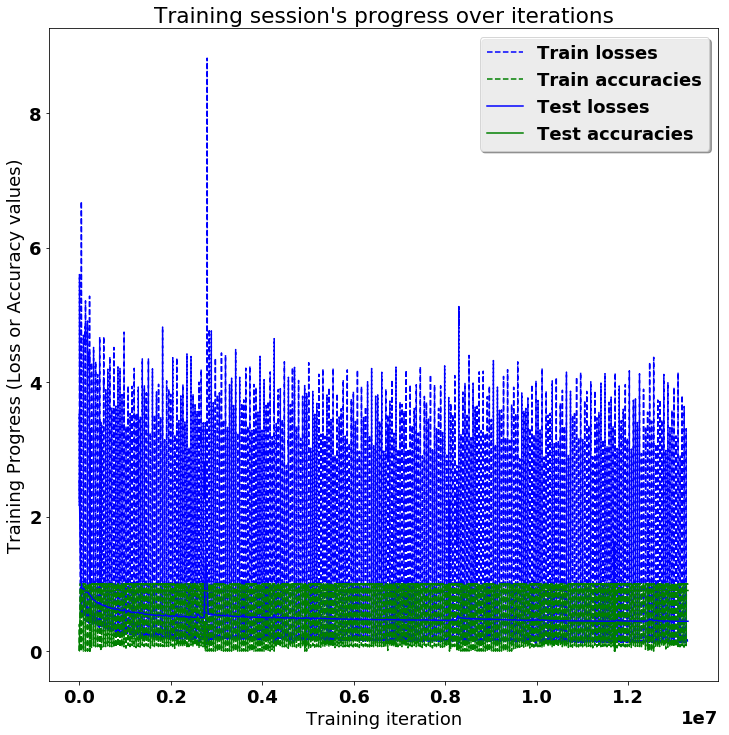

In [13]:
font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 18}

matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(config.batch_size, 
    (len(train_losses)+1)*config.batch_size, config.batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(config.batch_size, 
    len(test_losses)*config.display_iter, config.display_iter)[:-1]), 
    [config.training_epochs])

plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('har_lstm_loss_accuracy.png')
plt.show()

# multi-class confusion matrix and metrics plot

Testing Accuracy: 90.2411162853%

Precision: 80.6935489198%
Recall: 89.3509127789%
f1_score: 84.8018474618%

Confusion Matrix:
[[   0    0    0    0  615    0    0   79]
 [   0    0    0    0  108    0    0    0]
 [   0    0    0    0   93    0    0    0]
 [   0    0    0    0   36    0    0    6]
 [   0    0    0    0 7929    0    0    3]
 [   0    0    0    0    2    0    0    0]
 [   0    0    0    0    0    0    0    3]
 [   0    0    0    0    0    0    0    0]]

Confusion matrix (normalised to % of total test data):
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    6.93035889e+00   0.00000000e+00   0.00000000e+00   8.90241206e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.21703851e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.04800534e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e

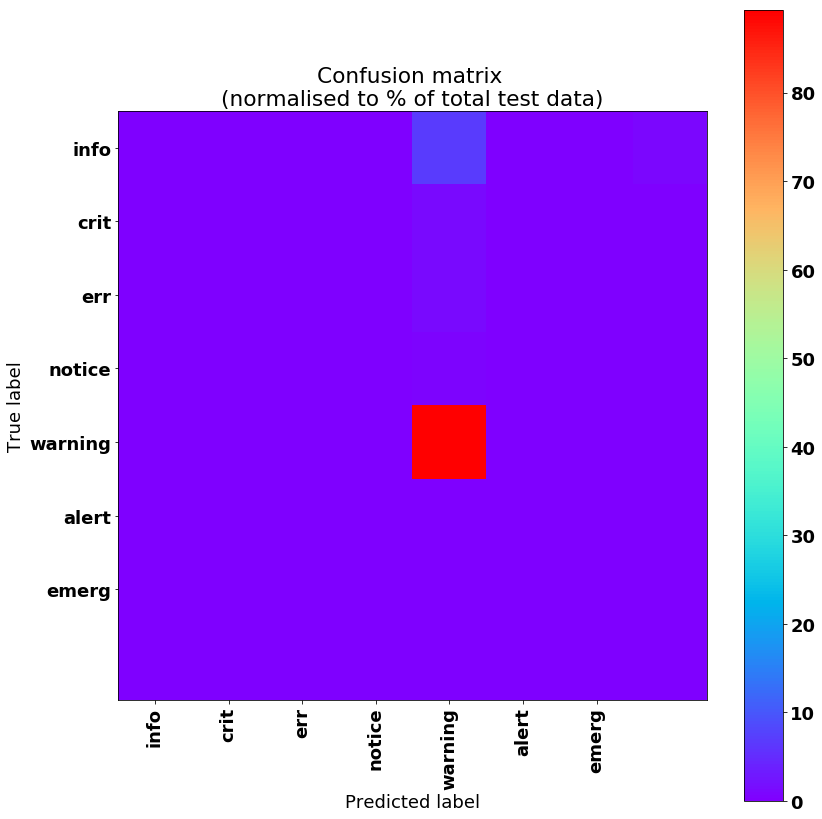

In [16]:
# Results
predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, 
    dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is \
    correctly classifier in the last category.")

# Plot: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(normalised_confusion_matrix, interpolation='nearest', cmap=plt.cm.rainbow)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(config.n_classes)
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('har_lstm_confusion_matrix_heatmap.png')
plt.show()